# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import gpt

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
bs=8
bptt=450

In [4]:
# PATH=Path('data/wikitext-2-raw')
PATH = Path('data/composers/notewise/piano_solo/note_range62/sample_freq12')
data = TextLMDataBunch.load(PATH, bs=bs, bptt=bptt)

In [5]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

158

In [6]:
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos wait25 wait25 wait25 wait25 wait25 wait25 wa',
 array([  2, 124, 124, 124, ...,   9, 105,   9, 157]))

In [7]:
# data.show_batch()

## Sanity - make sure outputs match

In [8]:
# learn = language_model_learner(data, drop_mult=1, clip=.5, bptt=250)

# ob = data.one_batch()

# out = learn.model(ob[0].cuda())

# out[0].shape

# len(out[1])

### Transformer Arch
Paper: https://arxiv.org/abs/1706.03762  
Inspiration: https://github.com/jadore801120/attention-is-all-you-need-pytorch

In [8]:
config = gpt.OpenAIGPTConfig(vocab_size)
# config = bert.BertConfig(vocab_size)

In [9]:
# config.n_embd = int(config.n_embd/2)
# config.n_layer = int(config.n_layer/2)
# config.n_head = int(config.n_head/2)

In [10]:
config

{
  "afn": "gelu",
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "initializer_range": 0.02,
  "n_ctx": 512,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_special": 0,
  "resid_pdrop": 0.1,
  "vocab_size": 158
}

In [11]:
# model = bert.BertForPreTraining(config).cuda()
model = gpt.OpenAIGPTLMHeadModel(config).cuda()
model.reset = lambda: None

In [11]:
# model

In [12]:
# ob = data.one_batch(); ob[0].shape

# out = model(ob[0].cuda())

# len(out)

# out[1].shape

# out[0].shape

### Create Language learner

In [12]:
learn = LanguageLearner(data, model, bptt, clip=1)

In [13]:
learn.callbacks = []

In [17]:
# learn = learn.to_fp16(32)

In [18]:
# learn.lr_find()

In [19]:
# learn.recorder.plot()

## Must remeber that BERT is bidirectional, so we must modifythe architechture so it won't cheat

In [ ]:
learn.fit_one_cycle(8, 5e-4, div_factor=10, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,0.920768,1.703815,0.606560
2,0.831417,1.525686,0.630738
3,1.063578,1.227003,0.670871


In [16]:
learn.save('gpt_first_run_fullmodel_save')

In [14]:
learn = learn.load('gpt_first_run_fullmodel_save')

In [15]:
learn.fit_one_cycle(1, 1e-4, div_factor=10, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,0.845847,0.912873,0.742985


In [16]:
learn.save('gpt_second_run_fullmodel_save')

In [17]:
learn.fit_one_cycle(4, 1e-4, div_factor=10, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,0.845941,1.019203,0.723947
2,0.829331,1.001427,0.730051


KeyboardInterrupt: 

In [18]:
learn.save('gpt_third_run_fullmodel_save')

In [19]:
learn.show_results()

text,target,pred
xxbos p28 p44 p47 wait3 p52 wait4 endp47 wait1 endp28 endp44 endp52 wait4 p23 p52 wait2 endp52 wait1 p51 wait2,wait1 p49 wait2 endp23 endp49 wait1 p47 wait2 endp47 wait1 p28 p52 wait5 endp28 endp52 wait1 p23 p47 wait5 endp23,wait1 p49 wait2 endp49 endp49 wait1 p51 wait2 endp47 wait1 p45 p45 wait2 endp52 endp52 wait1 p23 p47 wait5 endp23
p21 p45 wait5 endp45 wait1 p38 wait6 p9 wait5 endp38 wait1 p37 wait5 endp9 endp21 endp37 wait1 p14 p38 wait2,wait1 p37 wait2 endp37 wait1 p35 wait2 endp35 wait1 p33 wait2 endp14 endp33 wait1 p19 p31 wait1 p30 wait1 endp31,wait1 p40 wait2 endp37 wait1 p35 wait2 endp35 wait1 p33 wait2 endp14 endp33 wait1 p31 p35 wait2 p33 wait1 endp31
wait2 endp23 endp42 wait1 p44 wait2 endp44 wait1 p15 p46 wait2 endp46 wait1 p47 wait2 endp47 wait1 p46 wait2 endp15,wait1 p47 wait2 endp47 wait1 p16 p49 wait2 endp49 wait1 p47 wait2 endp47 wait1 p46 wait2 endp16 endp46 wait1 p44,wait1 p44 wait2 endp47 wait1 p23 p49 wait2 endp49 wait1 p47 wait2 endp47 wait1 p46 wait2 endp16 endp46 wait1 p44
p33 wait2 endp5 wait1 p7 wait2 endp7 endp33 wait1 p4 p31 wait2 endp4 endp31 wait1 p2 p29 wait2 endp2 wait1,wait2 endp4 endp24 wait1 p5 p23 wait2 endp5 endp29 wait1 p4 p31 wait2 endp4 wait1 p5 wait2 endp5 endp31 wait1,wait2 endp4 endp29 wait1 p5 p21 wait2 endp5 wait1 wait1 p7 wait2 wait2 endp4 endp31 p5 wait2 endp5 endp23 wait1
wait3 p25 p42 wait3 endp42 wait3 p44 wait2 endp25 wait1 endp44 wait3 p30 p46 wait3 endp30 endp46 wait3 p29 p44,endp29 endp44 wait3 p32 p47 wait3 endp32 endp47 wait3 p30 p46 wait3 endp30 endp46 wait3 p34 p49 wait3 endp34 endp49,endp29 endp44 wait3 p27 p42 wait3 endp32 endp47 wait3 p30 p46 wait3 endp30 endp46 wait3 p29 p49 wait3 endp34 endp49


In [56]:
path = PATH
idx = -4
folder_idx = 2 # 2 = bach
seed_len = 200

file = path.ls()[folder_idx].ls()[idx]
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len])

note_offset = 45 if 'note_range38' in str(file) else 33
sample_freq = 12 if 'sample_freq12' in str(file) else 4

note_offset, sample_freq, file

(33,
 12,
 PosixPath('data/composers/notewise/piano_solo/note_range62/sample_freq12/bach/pta6_5.txt'))

In [57]:
pred_out = learn.predict(seed, n_words=200)

In [58]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

'p48 p49 wait2 endp49 wait1 p48 wait5 endp32 endp39 endp48 wait1 p54 wait2 endp54 wait1 p51 wait2 endp51 wait1 p49 wait2 endp49 wait1 p48 wait2 endp48 wait1 p42 p45 wait8 endp45 wait1 p42 p51 wait8 endp51 wait1 p39 p48 wait8 endp48 wait1 p42 wait8 endp42 wait1 p36 p39 wait8 endp39 wait1 p33 p36 wait8 endp33 endp36 wait1 p34 p37 wait17 endp34 endp37 wait1 p36 p39 wait5 endp39 wait1 p33 p36 wait11 endp33 endp36 wait1 p29 p34 p37 wait5 endp29 endp34 endp37 wait1 p30 p33 p36 p39 wait17 endp30 endp33 endp36 wait1 p33 p39 p42 wait11 endp33 endp39 endp42 wait1 p29 p34 p37 p41 wait5 endp29 endp34 endp37 endp41 wait1 p30 p33 p36 p39 wait17 endp30 endp33 endp36 endp39 wait1 p29 p34 p37 wait5 endp29 wait1 p30 p34 p37 wait17 endp30 endp34 endp37 wait1 p29 p33 p36 wait5 endp29 wait1 p30 p33 p36 p39 wait17 endp30 endp33 endp36 endp39 wait1 p9 p21 p36 p39 p42 wait5 endp36 endp39 endp42 wait1 p9 p21 p37 p41 wait11 endp9 endp21 wait1 p10 p22 p37 wait5 endp10 endp22 endp37 endp41 wait1 p12 p24 p33 p39 w

In [59]:
from utils import *
import music21
from music21 import *
from IPython.display import Image, Audio

In [60]:
pred_format = pred_out.replace('xxbos ', '')

In [61]:
note_stream = arrToStreamNotewise(pred_format.split(' '), sample_freq=sample_freq, note_offset=note_offset)

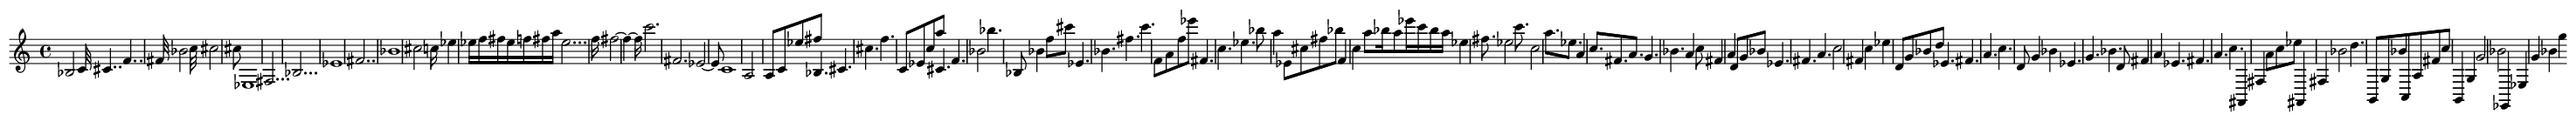

In [62]:
Image(filename=str(note_stream.write('lily.png')))

In [63]:
note_stream.show('midi')

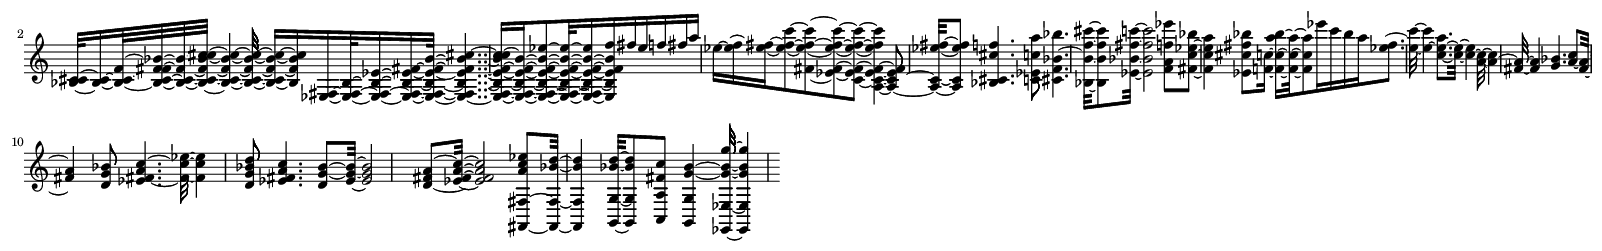

In [64]:
Image(filename=str(note_stream.chordify().write('lily.png')))